In [2]:
!pip install pytorch-lightning
!pip install torchmetrics

In [3]:
from pathlib import Path
import os
import torch
import cv2

import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

from PIL import Image

from torchsummary import summary

from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision.io import ImageReadMode
from torch.utils.data import DataLoader

import torchvision.transforms.v2 as transforms

import torch.optim as optim
import torchmetrics
from torchmetrics.image import StructuralSimilarityIndexMeasure

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
data_path = Path("data")

# Cityscapes Dataset

In [5]:
class CityscapesDataLoader(Dataset):
    def __init__(self, path_data, split, augmentation=None):
        self.path_data = path_data
        self.path_images = path_data / 'left_images' / split
        self.path_depth = path_data / 'depth' / split
        self.all_path_images = [img for img in self.path_images.iterdir() if img.suffix == ".png"]
        self.augmentation = augmentation
        #print('self.all_path_images: ', self.all_path_images)
        #print('type self.all_path_images: ', type(self.all_path_images))

    def __len__(self):
        return len(self.all_path_images)

    def __getitem__(self, idx):
        path_image_i = self.all_path_images[idx]
        name = path_image_i.stem[:-11] #discard last 11 letters because these are '_left_image'
        path_depth_i = self.path_depth / (name + '_depth_image.png')

        image = read_image(path_image_i)
        depth = read_image(path_depth_i, ImageReadMode.GRAY)

        if self.augmentation:
          image = self.augmentation(image)
          depth = self.augmentation(depth)

        image = image.float()
        depth = depth.float()

        return image, depth

In [6]:
""" Resize to 384 as the model we use needs that size """
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
])

train_data = CityscapesDataLoader(data_path, 'train', augmentation=transform)
val_data = CityscapesDataLoader(data_path, 'val', augmentation=transform)
test_data = CityscapesDataLoader(data_path, 'test', augmentation=transform)

image_0_transformed, depth_0_transformed = train_data[0]
image_0_transformed.shape, depth_0_transformed.shape

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


(torch.Size([3, 384, 384]), torch.Size([1, 384, 384]))

In [7]:
print(f"number of elements in the train_dataset is: {len(train_data)}")
print(f"number of elements in the val_dataset is: {len(val_data)}")
print(f"number of elements in the test_dataset is: {len(test_data)}")

number of elements in the train_dataset is: 2975
number of elements in the val_dataset is: 500
number of elements in the test_dataset is: 1525


# DataLoaders

In [8]:
train_loader = DataLoader(train_data, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=8, shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=8, shuffle=False, num_workers=2)

In [9]:
# Assuming your dataloader is named 'train_dataloader'
first_batch = next(iter(train_loader))  # Get the first batch

# Unpack the batch to access the images (x) and labels (y)
x, y = first_batch

# Now you can access the images and labels
print(f"x shape: {x.shape}, y shape: {y.shape}")

x shape: torch.Size([8, 3, 384, 384]), y shape: torch.Size([8, 1, 384, 384])


# Loading The model

In [10]:
model = torch.hub.load("intel-isl/MiDaS", "DPT_Hybrid")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
summary(model, input_size=(3, 384, 384))

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
     StdConv2dSame-1         [-1, 64, 192, 192]           9,408
          Identity-2         [-1, 64, 192, 192]               0
              ReLU-3         [-1, 64, 192, 192]               0
      GroupNormAct-4         [-1, 64, 192, 192]             128
     MaxPool2dSame-5           [-1, 64, 96, 96]               0
     StdConv2dSame-6          [-1, 256, 96, 96]          16,384
          Identity-7          [-1, 256, 96, 96]               0
          Identity-8          [-1, 256, 96, 96]               0
      GroupNormAct-9          [-1, 256, 96, 96]             512
   DownsampleConv-10          [-1, 256, 96, 96]               0
    StdConv2dSame-11           [-1, 64, 96, 96]           4,096
         Identity-12           [-1, 64, 96, 96]               0
             ReLU-13           [-1, 64, 96, 96]               0
     GroupNormAct-14           [-1, 64,

In [15]:
class MiDaSFineTuner(pl.LightningModule):
    def __init__(self, learning_rate=5e-5):
        super().__init__()
        self.model = torch.hub.load("intel-isl/MiDaS", "DPT_Hybrid")
        self.learning_rate = learning_rate
        self.loss_fn = nn.L1Loss()


        self.train_ssi = StructuralSimilarityIndexMeasure(data_range=1.0)
        self.val_ssi = StructuralSimilarityIndexMeasure(data_range=1.0)
        self.test_ssi = StructuralSimilarityIndexMeasure(data_range=1.0)

        for param in self.model.parameters():
          param.requires_grad = True

        for param in self.model.scratch.output_conv.parameters():
          param.requires_grad = True

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y / 255
        y_hat = self(x)
        y_hat = (y_hat - y_hat.min()) / (y_hat.max() - y_hat.min())

        y_hat = y_hat.unsqueeze(1)
        #visualize_prediction(x, y_hat, y)
        loss = self.loss_fn(y_hat, y)

        train_ssi = self.train_ssi(y_hat, y)

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_ssi", train_ssi, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def on_train_epoch_end(self):
        self.train_ssi.reset()

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y / 255
        y_hat = self(x)
        y_hat = (y_hat - y_hat.min()) / (y_hat.max() - y_hat.min())

        y_hat = y_hat.unsqueeze(1)
        #visualize_prediction(x, y_hat, y)

        loss = self.loss_fn(y_hat, y)
        val_ssi = self.val_ssi(y_hat, y)

        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_ssi", val_ssi, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def on_validation_epoch_end(self):
        self.val_ssi.reset()


    def test_step(self, batch, batch_idx):
        x, y = batch

        y = y / 255
        y_hat = self(x)
        y_hat = (y_hat - y_hat.min()) / (y_hat.max() - y_hat.min())

        y_hat = y_hat.unsqueeze(1)

        #visualize_prediction(x, y_hat, y)

        loss = self.loss_fn(y_hat, y)
        test_ssi = self.test_ssi(y_hat, y)

        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("test_ssi", test_ssi, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def on_test_epoch_end(self):
        self.test_ssi.reset()

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

# Model and trainer initialization

In [19]:
model_ = MiDaSFineTuner()

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints',
    filename='MiDaS_small_1',
    save_top_k=1,
    mode='min'
)

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    mode='min'
)

trainer = Trainer(max_epochs=15,
                  accelerator="gpu" if torch.cuda.is_available() else "cpu",  # Use GPU if available
                  devices=1,  # Number of GPUs or CPUs
                  log_every_n_steps=1,
                  callbacks = [checkpoint_callback, early_stop_callback]
                  )

# Start training
trainer.fit(model_, train_loader, val_loader)

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | DPTDepthModel                    | 1

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [20]:
trainer.test(dataloaders=test_loader, ckpt_path="checkpoints/DPT_Hybrid_1-v3.ckpt")

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at checkpoints/DPT_Hybrid_1-v3.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at checkpoints/DPT_Hybrid_1-v3.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.02790706232190132    │
│         test_ssi          │    0.9042763710021973     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.02790706232190132, 'test_ssi': 0.9042763710021973}]

## Test on test images

In [ ]:
model_load = MiDaSFineTuner.load_from_checkpoint("checkpoints/best-checkpoint-1.ckpt")
model_load.eval()

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(


MiDaSFineTuner(
  (model): DPTDepthModel(
    (pretrained): Module(
      (model): VisionTransformer(
        (patch_embed): HybridEmbed(
          (backbone): ResNetV2(
            (stem): Sequential(
              (conv): StdConv2dSame(3, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
              (norm): GroupNormAct(
                32, 64, eps=1e-05, affine=True
                (drop): Identity()
                (act): ReLU(inplace=True)
              )
              (pool): MaxPool2dSame(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), dilation=(1, 1), ceil_mode=False)
            )
            (stages): Sequential(
              (0): ResNetStage(
                (blocks): Sequential(
                  (0): Bottleneck(
                    (downsample): DownsampleConv(
                      (conv): StdConv2dSame(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                      (norm): GroupNormAct(
                        32, 256, eps=1e-05, affine=True
        

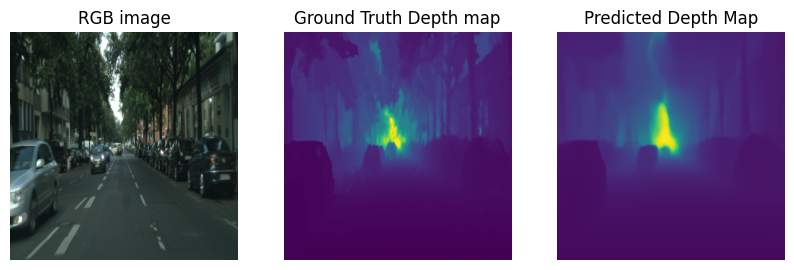

In [ ]:
def denormalize(image):
    # Denormalize the image
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()  # Convert to NumPy array
    image = image.transpose(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    return image

def visualizer(rgb_image, depth_image, depth_map):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # Create a subplot with 1 row and 3 columns

    axes[0].imshow(rgb_image)
    axes[0].set_title("RGB image")
    axes[0].axis("off")

    # Display the RGB image
    axes[1].imshow(depth_image, cmap="viridis")
    axes[1].set_title("Ground Truth Depth map")
    axes[1].axis("off")

    # Display the depth map
    axes[2].imshow(depth_map, cmap="viridis")
    axes[2].set_title("Predicted Depth Map")
    axes[2].axis("off")

    plt.show()


def predict(img):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    img = img.to(device)  # Move input tensor to the correct device
    model_load.to(device)  # Ensure the model is on the correct device

    with torch.no_grad():  # Disable gradient calculation
        output = model_load(img)

    depth_map = output.squeeze().cpu().numpy()  # Remove batch dimension and convert to numpy array
    return depth_map


image, depth = next(iter(test_loader))  # Get a batch of images and depths
rgb_image = denormalize(image[7])  # Denormalize image in the batch
depth_image = denormalize(depth[7]) #  Denormalize depth map in the batch
depth_map = predict(image)  # Predict depth map for the batch
visualizer(rgb_image, depth_image, depth_map[7])  # Visualize RGB-GT-Predicted